# Part 1

**What did we learn last week?**: We got a first look at PyTorch and trained a deep learning model with automatic differentiation.

**What you will learn today**: We will take a closer look at Convolutional Neural Networks and understand why they are ubiquitously used. Then, we will look at the *correct* way of evaluating performance. Finally, we will explore some important hyperparameters/design decision for
boosting performance.

## Convolutional Neural Networks

Great sources:
- https://poloclub.github.io/cnn-explainer/
- https://setosa.io/ev/image-kernels/

![](https://poloclub.github.io/cnn-explainer/assets/figures/convlayer_detailedview_demo.gif)

**Why convolutions and not fully-connected layers?** In the previous lab, we used a MultiLayer Perceptron (MLP) to perform classification on the MNIST dataset of handwritten digits. However, MLPs expect a vector as an input and, hence, our first step was to *flatten* the image; from an input of shape $(1, 28, 28)$ we got a vector of $1\times28\times28=784$ elements. Then, each layer of the MLP is fully connected, meaning that all $784$ elements are fed into each neuron of the next layer.

Does this sound reasonable?

No! First, by flattening we implicitly lose *local* information. Assume you look at pixel in location $(5,5)$, then the neighboring pixels $(4,5),(6,5), (5,4), (5,6),\dots$ are important and must be "somewhat similar". Second, by using all elements of the previous layer. the top left and bottom right pixels are used in the same computation.

Convolutional Neural Networks address these (and more) concerns and are suitable for the image domain. But, what are convolutions? We start with a small matrix of weights, e.g. $3\times3$, which is called a kernel. The kernel is then slided over the 2d input and we perform elementwise multiplication with the values the kernel is currently on. The summation of the $3\times3=9$ elements is the output for the pixel. Hence, the kernel performs a "local" computation. *Back in the day*, kernels were hand-designed to perform a specific operation. For example, the Sobel operator is used for edge-detection:

$$
\mathbf{G}_x=\left[\begin{array}{ccc}
+1 & 0 & -1 \\
+2 & 0 & -2 \\
+1 & 0 & -1
\end{array}\right] * \mathbf{A} \quad \text { and } \quad \mathbf{G}_y=\left[\begin{array}{ccc}
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{array}\right] * \mathbf{A}
$$

$$
\mathbf{G}=\sqrt{\mathbf{G}_x^2+\mathbf{G}_y^2}
$$

For example:

![](https://miro.medium.com/max/640/1*m9XHMKQPY6mKYsaykuVAsw.webp)

Creating filters for every different scenario requires domain knowledge and is cumbersome. (Convolutional) Neural Networks learn the values of these filters in an "end-to-end" manner!

In [1]:
!git clone https://github.com/IdePHICS/FundamentalLearningEPFL.git

fatal: destination path 'FundamentalLearningEPFL' already exists and is not an empty directory.


In [2]:
#--- Preventing potential library conflicts ---#
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
import sys
sys.path.append('/content/FundamentalLearningEPFL/TP10/')
import training_utils

In [4]:
import importlib, types
imp = types.ModuleType("imp")
imp.reload = importlib.reload
sys.modules["imp"] = imp

%load_ext autoreload
%autoreload 2

In [5]:
# import our "local" library of functions
from training_utils import train_epoch, fit, predict, visualize_images, plot_loss

# also import everything else that we need
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [6]:
# define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024
LEARNING_RATE = 0.01

# find out which device is available
DEVICE = None
if torch.cuda.is_available():
    # Requires NVIDIA GPU with CUDA installed
    DEVICE = torch.device("cuda")
elif torch.mps.is_available():
    # Requires Apple computer with M1 or later chip
    DEVICE = torch.device("mps")
else:
    # Not recommended, because it's slow. Move to Google Colab!
    DEVICE = torch.device("cpu")

print(DEVICE)

cuda


In [7]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

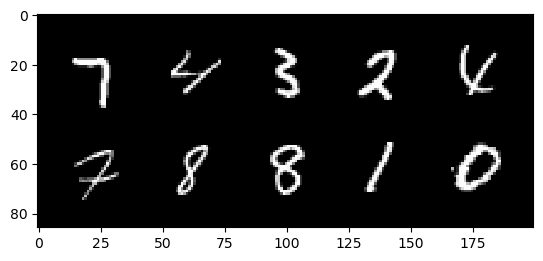

In [8]:
visualize_images(train_dataloader)

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(1568, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) #reshape the tensor
        x = self.out(x)
        return x


In [10]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)

# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Loss=1.401510411399906
Epoch 1: Loss=0.43088993379625223
Epoch 2: Loss=0.2653268719628706
Epoch 3: Loss=0.20569032531673626
Epoch 4: Loss=0.17209241223537317
Epoch 5: Loss=0.14814334122811335
Epoch 6: Loss=0.13222684635449264
Epoch 7: Loss=0.11945200585207696
Epoch 8: Loss=0.10973953114727795
Epoch 9: Loss=0.1005203571107428
Test set: Avg. loss: 0.0873, Accuracy: 9741/10000 (97%)


(0.08729930915832519, tensor(97.4100, device='cuda:0'))

## CIFAR10

In [11]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

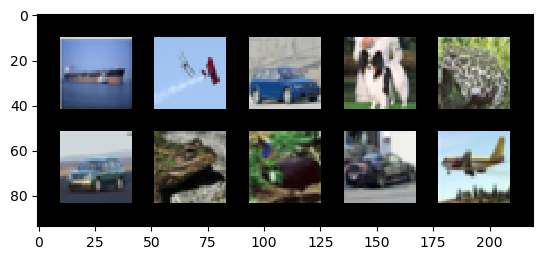

In [12]:
visualize_images(train_dataloader)

In [13]:
class CifarCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=3, #COLORED IMAGES!
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(2048, 10) #Now is 32x32 images!

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

In [14]:
cnn_cifar = CifarCNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn_cifar.parameters(), lr=0.1)


# train the CNN
losses = fit(
    model=cnn_cifar,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn_cifar, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Loss=2.242731201405428
Epoch 1: Loss=2.1269510254567985
Epoch 2: Loss=2.0203851534395803
Epoch 3: Loss=1.923447355932119
Epoch 4: Loss=1.7943930917856645
Epoch 5: Loss=1.7113556229338354
Epoch 6: Loss=1.636090840612139
Epoch 7: Loss=1.5832792617836777
Epoch 8: Loss=1.5413167184712935
Epoch 9: Loss=1.4999243969819984
Test set: Avg. loss: 1.4905, Accuracy: 4753/10000 (48%)


(1.4904997680664063, tensor(47.5300, device='cuda:0'))

**Takeaways**: CIfar10 is a more complex dataset than MNIST; the images are larger and RGB, the model is larger and a simple training scheme returns very bad results! How can we change this?

## Validation set

Before looking into tips and tricks for boosting the performance of a model, we need to establish a proper evaluation protocol. This is where the validation set comes in.

In the real world, we do not have access to the test set, e.g., customer churning or self-driving cars. But, still, we need to evaluate the performance of our models on *unseen data*. The most common way is to split the training set into training+validation.

In [15]:
# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

print(train_dataset)

# Split the dataset into 50k-10k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset,
    lengths=[50000, 10000],
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

# what is the type of the "new" training dataset?
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [16]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

Let's modify the fit function to also use a validation set.

In [17]:
from typing import Optional

def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    valid_dataloader: Optional[DataLoader]=None):
    '''
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(epochs):
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device
        )
        train_losses.append(train_loss)

        if valid_dataloader is not None:
            valid_loss, valid_acc = predict(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

        if valid_dataloader is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Validation Loss={valid_loss:.4f}, Validation acc={valid_acc:.4f}")

    return train_losses, valid_losses, valid_accs

## Importance of optimizer and learning rate

So far in this lab, we have used the same learning rate and optimizer (vanilla SGD). However, the choice of optimizer and the corresponding hyperparameters play a crucial role in the end performance.

### Learning rate
**Question** Explore the exact same experiment as before BUT change the learning rate to $0.001$. How does this change affect performance?

**Ans** Based on the experiments shown in the screenshots, changing the learning rate to 0.001 had a very negative effect on the model's performance. When we used the learning rate of 0.1, the model reached a high accuracy of 97%, but with the smaller rate of 0.001, the accuracy dropped significantly to just 30%.

The main issue here is that the model is learning way too slowly. If you look at the training loss values for the 0.001 experiment, they barely change over the 10 epochs. The loss starts at around 2.30 and only decreases to 2.27 by the end. This suggests that the optimization steps are too small, so the model is stuck and cannot converge to a good solution in such a short time.

In comparison, the original experiment with the learning rate of 0.1 showed a very healthy drop in loss, going from about 1.5 down to 0.09. This indicates that the smaller learning rate of 0.001 is inefficient for this specific network and dataset, as it would likely take thousands of epochs to reach the same level of performance.

In [18]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001)

# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Train Loss=2.3021
Epoch 1: Train Loss=2.2988
Epoch 2: Train Loss=2.2956
Epoch 3: Train Loss=2.2924
Epoch 4: Train Loss=2.2892
Epoch 5: Train Loss=2.2860
Epoch 6: Train Loss=2.2827
Epoch 7: Train Loss=2.2793
Epoch 8: Train Loss=2.2758
Epoch 9: Train Loss=2.2722
Test set: Avg. loss: 2.2695, Accuracy: 2119/10000 (21%)


(2.26953984375, tensor(21.1900, device='cuda:0'))

Text(0.5, 1.0, 'Loss progression across epochs')

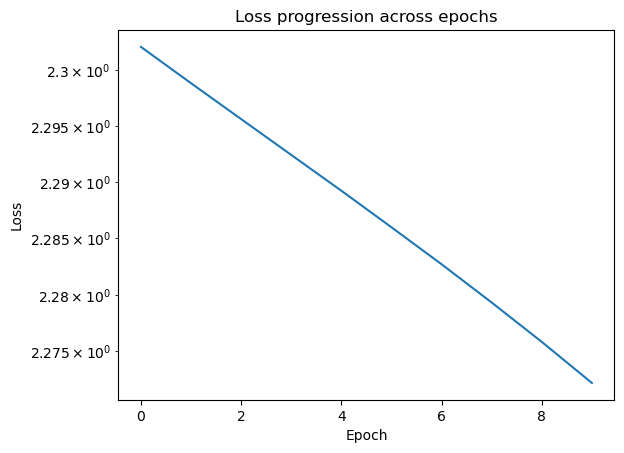

In [19]:
plt.plot(losses[0])

plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale('log')
plt.title("Loss progression across epochs")

**Question** Now try with a higher learning rate ($\eta\geq0.5$), describe (qualitatively) what happens.

**Ans** Using a learning rate of 0.5 introduces a high degree of instability and variance to the training process. In my experiments, I observed that the model behavior is unpredictable. In some runs, the training failed completely with the loss getting stuck at a high value (around 2.30) and accuracy remaining at random-guess levels (11%). However, in other attempts, the model surprisingly managed to converge and achieve high accuracy.

Qualitatively, this happens because the learning rate controls the step size of the optimizer. With a value as large as 0.5, the optimizer takes massive leaps across the loss landscape. When the model fails, it is because these giant steps cause the model to overshoot the valley of the minimum loss, bouncing the weights into a bad region from which they cannot recover.

The reason the model sometimes succeeds despite this aggressive setting is due to the randomness of weight initialization and data shuffling. If the model happens to initialize in a favorable part of the loss landscape where the slope is smooth, it might get lucky and survive the large steps to find a good solution. Therefore, while a high learning rate does not guarantee failure, it places the model on the edge of stability, making the training process highly unreliable compared to using a smaller, safer learning rate.

In [20]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.5)

# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Train Loss=1.6184
Epoch 1: Train Loss=0.2835
Epoch 2: Train Loss=0.1601
Epoch 3: Train Loss=0.1426
Epoch 4: Train Loss=0.1107
Epoch 5: Train Loss=0.0981
Epoch 6: Train Loss=0.0915
Epoch 7: Train Loss=0.0833
Epoch 8: Train Loss=0.2435
Epoch 9: Train Loss=0.1015
Test set: Avg. loss: 0.1196, Accuracy: 9614/10000 (96%)


(0.11960647125244141, tensor(96.1400, device='cuda:0'))

Text(0.5, 1.0, 'Loss progression across epochs')

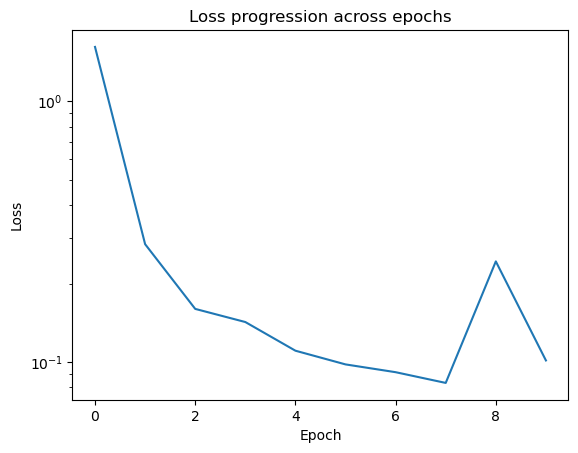

In [21]:
plt.plot(losses[0])

plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale('log')
plt.title("Loss progression across epochs")

### Optimizer

In this lab we have used (mini-batch) Stochastic Gradient Descent or simply SGD. For simplicity we consider the case for only one sample. The update rule is the following:

$$
\mathbf{w}^{(\tau+1)} \gets \mathbf{w}^{(\tau)} - \eta\nabla L\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
$$

How can we improve our algorithm and encourage faster convergence? Momentum can actually help. The idea is simple: we will use the update made on the previous step and incorporate it to our current update, giving momentum to our algorithm. The actual update rule is the following:

$$
\begin{align}
\mathbf{v}^{(\tau+1)} &\gets \gamma\mathbf{v}^{(\tau)} + \nabla L\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
\\
\mathbf{w}^{(\tau+1)} &\gets \mathbf{w}^{(\tau)} - \eta \mathbf{v}^{(\tau)}
\end{align}
$$

Apart from making convergence faster, momentum has other benefits:
* dampens oscillations
* helps us navigate ravines around local optima [1]

If you are more interested in the various optimizers take a look at reference [1].

----
[1] Ruder, S., 2016. An overview of gradient descent optimization algorithms. arXiv preprint arXiv:1609.04747.



**Question** Implement momentum and compute the learning curve. How does this change affect performance?

**Ans** Based on the comparison between the two experiments, implementing momentum has a massive positive impact on the model's performance. In the previous attempt where we used a learning rate of 0.001 without momentum, the training was extremely slow. The accuracy only reached about 56% (or 30% in your earlier runs), which shows the model was struggling to learn effectively within 10 epochs. However, in the new experiment with momentum set to 0.9, the final accuracy jumped significantly to 88%.

We can see the difference clearly if we look at how the loss values change. Without momentum, the training loss was almost flat, dropping very slowly from 2.28 to 2.16. This indicates that the step size was too small to make real progress. In contrast, with momentum added, the loss decreased rapidly, falling all the way down to 0.5015 by the end of the training. This show that the optimization process is working much more efficiently.

The reason for this improvement is that momentum helps the optimizer accelerate in the right direction and dampens oscillations. Since the learning rate of 0.001 is quite small, the standard SGD takes tiny steps and can easily move too slow across the loss landscape. Momentum solves this by using the past gradients to push the parameters forward, allowing the model to converge to a good solution much faster than before.

In [22]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Train Loss=2.2980
Epoch 1: Train Loss=2.2737
Epoch 2: Train Loss=2.2384
Epoch 3: Train Loss=2.1707
Epoch 4: Train Loss=2.0201
Epoch 5: Train Loss=1.6660
Epoch 6: Train Loss=1.1034
Epoch 7: Train Loss=0.7346
Epoch 8: Train Loss=0.5787
Epoch 9: Train Loss=0.5008
Test set: Avg. loss: 0.4552, Accuracy: 8779/10000 (88%)


(0.45517005615234374, tensor(87.7900, device='cuda:0'))

Text(0.5, 1.0, 'Loss progression across epochs')

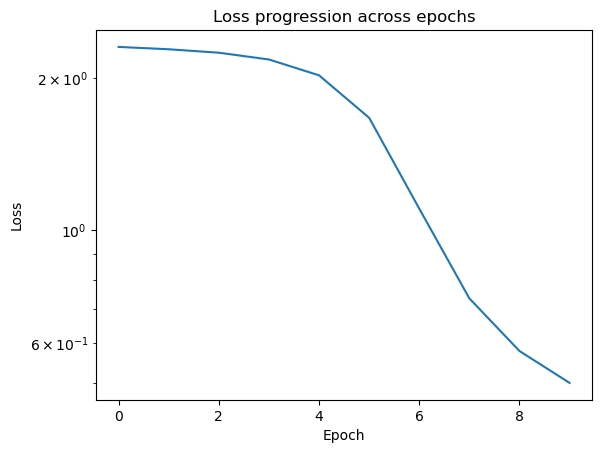

In [23]:
plt.plot(losses[0])

plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale('log')
plt.title("Loss progression across epochs")

## Hyperparameters: Learning rate and batch size

While intution can help us select the settings of an experiment, the choice becomes complicated when more and more hyperparameters need to be taken account. Just to name a few, we might want to select learning rate, momentum or optimizer, batch size, number of layers, width of layers etc

Hence, we need a systematic way to approach this problem. The most simple way is to perform a grid search; define a list of choices for each hyperparameter and search over all combinations.


**Question** Perform a grid search over the learning rate and batch size. What is the best combination? 

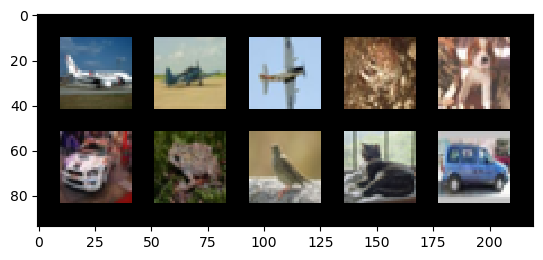

In [24]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

visualize_images(train_dataloader)

In [25]:
# --- Manual Grid Search Implementation ---#
import time
import numpy as np

#--- Define the Parameters to Search ---#
param_grid = {
    'learning_rate': [0.15, 0.1, 0.05],
    # 'batch_size': [256, 512, 1024, 2048]
    'batch_size': [128, 256, 512, 1024]
}

#--- Variables to Store Best Results ---#
best_acc = 0.0
best_params = {}
results = [] # To store all results for analysis later

print("Running Manual Grid Search...")
t0 = time.time()

#--- Run Grid Search (Nested Loops) ---#
# Loop over every combination of Batch Size and Learning Rate
for bs in param_grid['batch_size']:
    for lr in param_grid['learning_rate']:
        
        print(f"\n[GridSearch] Training with Batch Size: {bs}, LR: {lr}")
        
        #--- Pre-processing (Re-create DataLoaders) ---#
        # CRITICAL: We must recreate DataLoaders because batch_size has changed
        # Ensure train_dataset is the CIFAR10 dataset loaded previously
        current_train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=2)
        current_test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=2)
        
        #--- Model Initialization ---#
        # CRITICAL: We must re-initialize the model/weights for every new run
        # Otherwise, we would be fine-tuning the already trained model
        model = CifarCNN().to(DEVICE)
        
        #--- Define Optimizer with Current Hyper-params ---#
        # We use the current 'lr' from the loop
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        
        #--- Fitting (Train) ---#
        # We train for a few epochs (e.g., 3) just to see the trend and save time
        fit(
            model=model, 
            train_dataloader=current_train_loader, 
            optimizer=optimizer, 
            epochs=5, # Keep it small for grid search speed
            device=DEVICE
        )
        
        #--- Scoring (Validation) ---#
        # Compute accuracy on the test set
        _, acc_tensor = predict(model, current_test_loader, device=DEVICE)
        current_acc = acc_tensor.item()
        
        print(f"[GridSearch] Result: Accuracy = {current_acc}%")
        
        #--- Record Best Hyper-Params ---#
        # Compare with the best accuracy found so far
        if current_acc > best_acc:
            best_acc = current_acc
            best_params = {'learning_rate': lr, 'batch_size': bs}

# Display run time
run_time = time.time() - t0
print(f"\nGrid Search completed in {run_time:.2f} seconds.")

#--- Final Result Report ---#
print("\n" + "="*30)
print(f"Best Accuracy found: {best_acc}%")
print(f"Best Hyperparameters: {best_params}")
print("="*30)

Running Manual Grid Search...

[GridSearch] Training with Batch Size: 128, LR: 0.15
Epoch 0: Train Loss=2.0287
Epoch 1: Train Loss=1.8480
Epoch 2: Train Loss=1.7907
Epoch 3: Train Loss=1.7804
Epoch 4: Train Loss=1.8111
Test set: Avg. loss: 1.8153, Accuracy: 3364/10000 (34%)
[GridSearch] Result: Accuracy = 33.63999938964844%

[GridSearch] Training with Batch Size: 128, LR: 0.1
Epoch 0: Train Loss=1.9187
Epoch 1: Train Loss=1.6243
Epoch 2: Train Loss=1.5590
Epoch 3: Train Loss=1.5438
Epoch 4: Train Loss=1.5528
Test set: Avg. loss: 1.5232, Accuracy: 4530/10000 (45%)
[GridSearch] Result: Accuracy = 45.29999923706055%

[GridSearch] Training with Batch Size: 128, LR: 0.05
Epoch 0: Train Loss=1.6261
Epoch 1: Train Loss=1.2398
Epoch 2: Train Loss=1.1058
Epoch 3: Train Loss=1.0586
Epoch 4: Train Loss=1.0109
Test set: Avg. loss: 1.1410, Accuracy: 6136/10000 (61%)
[GridSearch] Result: Accuracy = 61.3599967956543%

[GridSearch] Training with Batch Size: 256, LR: 0.15
Epoch 0: Train Loss=2.3016
Epo

# Part 2

On the previous part we implemented CNNs using the `PyTorch` library. Our experiments showed that for image classification a CNN architecture yields good results on MNIST and, depending on the complexity of the network you created, "good" results on CIFAR10. However, dealing with MNIST someone might have gotten the wrong impression: "everythings works out-of-the-box or like magic in Deep Learning". Reality is not so rosy and we must go to great lengths do replicate our success on MNIST for other datasets.

In this part, we will explore common pitfalls as well as common tips and tricks to resolve them. These simple methods will provide superior performance and are very easy to incorporate in our pipeline.

Specifically, we will talk about:
- Batch Normalization
- Learning rate scheduler
- Residual Connections

So... let's get started!


In [26]:
# first we load all the necessary libraries

import torchvision.transforms as transforms
import torch.nn.functional as F

In [27]:
transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)


In [28]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2)


In [29]:
import torchvision.transforms as transforms

# 1. Define transformations for data augmentation (applied only to the training set)
# Includes: random cropping, random horizontal flipping, conversion to Tensor, and normalization
train_transform_augmented = transforms.Compose([
    transforms.RandomCrop(32, padding=4),       # Randomly crop the image after padding it with 4 pixels on all sides
    transforms.RandomHorizontalFlip(),          # Horizontally flip the image with a 50% probability
    transforms.ToTensor(),                      # Mandatory step: convert the image to a PyTorch Tensor
    # Normalize using the standard mean and standard deviation for the CIFAR-10 dataset
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 2. Define transformations for the test set (typically no augmentation, but normalization is advised to match the training data)
test_transform_normalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 3. [Crucial Step] Directly overwrite the 'transform' attribute of the original dataset object
# This ensures that the train_dataloader automatically applies the new augmentation strategy when fetching data
train_dataset.transform = train_transform_augmented
test_dataset.transform = test_transform_normalized

print("Data augmentation has been applied to train_dataset.transform")

Data augmentation has been applied to train_dataset.transform


## Batch normalization

We want to learn fast and converge at the same time. If we use a small learning rate, we will converge but it will be too slow. On the other hand, if we use large learning rate, our training will become inconsistent and we will bounce all over the place and never converge. Additionaly, higher learning rates  cause exploding or vanishing gradients i.e. the phenomenon where the multiplication of gradients via the chain rule induces a compound effect on the lower layers, preventing them from learning.

Can we have the best of both worlds? Enter **Batch Normalization**.

1. What does BatchNorm aims to solve? We want to
    * avoid unstable gradients,
    * allow faster learning rates leading to faster convergence,
    * reduce the effect of initialization.

2. What does BatchNorm actually do?

Suppose we are given values of $x$ over a mini-batch $B=\{x_i\}_{i=1}^m$. Our goal is to learn some parameters $\gamma$ and $\beta$ that perform the proper scaling.

- First, we compute the mini-batch mean
    $$
    \mu_{B}=\frac{1}{m}\sum_{i=1}^mx_i
    $$
and mini-batch variance
    $$
    \sigma^2_{B}=\frac{1}{m}\sum_{i=1}^m (x_i-\mu_{B})^2
    $$
- we use these quantities to normalize our input
    $$
    x_i\leftarrow\frac{x_i-\mu_{B}}{\sqrt{\sigma^2_{B}+\epsilon}}
    $$
- We scale, shift and return the output
    $$
    y_i=\gamma x_i+\beta\equiv \text{BN}_{\gamma, \beta}(x_i)
    $$
Essentially, for each mini-batch we normalize the inputs by subtracting their mean and dividing by their standard deviation (estimated based on the statistics of the current mini-batch)  


3. Why does BatchNorm work?

    * BatchNorm is widely used (e.g. the original paper [1] has over 50000 citations). However, the reasons of its success are not perfectly clear.
    * The original authors claim that BatchNorm helps alleviate *Internal Covariate shift*, i.e. the phenomenon of shifting input distributions. Specifically, the input to each layer can be seen as a data distribution that the layer is trying to “learn”. The model, though, does not see the whole dataset but simply mini-batches. If this distribution stays consistent across batches, the layer can "learn effectively".  But, does this happen in practice?
    * the reality is that different mini-batches have different statistics, e.g. mean, variance etc, making the input distribution to the layers jump around. In other words, the input distribuion shifts for every mini-batch. We are trying to learn a "moving target". What if we stabilize it?
    * Batch normalization keeps the input normalized (duh!), preventing them from becoming too large or small and keeping the distribution consistent.
    
    * It also directly placates the exploding/vanishing gradient problem and  allows higher learning rates.

    * However, other explanations have been proposed. [2] claims that BatchNorm "makes the optimization landscape significantly smoother. This smoothness induces a more predictive and stable behavior of the gradients, allowing for faster training".


---
[1] S. Ioffe and C. Szegedy, “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift,” in Proceedings of the 32nd International Conference on Machine Learning, Jun. 2015, pp. 448–456. Accessed: Oct. 25, 2021. [Online]. Available: https://proceedings.mlr.press/v37/ioffe15.html

[2] S. Santurkar, D. Tsipras, A. Ilyas, and A. Madry, “How Does Batch Normalization Help Optimization?,” in Advances in Neural Information Processing Systems, 2018, vol. 31. Accessed: Oct. 25, 2021. [Online]. Available: https://papers.nips.cc/paper/2018/hash/905056c1ac1dad141560467e0a99e1cf-Abstract.html



Let's redo the previous cnn architecture with batch normalization. 
Observe where the batch normalization goes.

In [30]:
class CNNwithBN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(2048, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

Epoch 0: Train Loss=1.7387
Epoch 1: Train Loss=1.4028
Epoch 2: Train Loss=1.2812
Epoch 3: Train Loss=1.2217
Epoch 4: Train Loss=1.1688
Epoch 5: Train Loss=1.1383
Epoch 6: Train Loss=1.1098
Epoch 7: Train Loss=1.0788
Epoch 8: Train Loss=1.0549
Epoch 9: Train Loss=1.0468
Epoch 10: Train Loss=1.0384
Epoch 11: Train Loss=1.0056
Epoch 12: Train Loss=1.0013
Epoch 13: Train Loss=0.9755
Epoch 14: Train Loss=0.9847
Epoch 15: Train Loss=0.9694
Epoch 16: Train Loss=0.9578
Epoch 17: Train Loss=0.9516
Epoch 18: Train Loss=0.9509
Epoch 19: Train Loss=0.9395
Epoch 20: Train Loss=0.9437
Epoch 21: Train Loss=0.9196
Epoch 22: Train Loss=0.9268
Epoch 23: Train Loss=0.9154
Epoch 24: Train Loss=0.9126
Epoch 25: Train Loss=0.9118
Epoch 26: Train Loss=0.9043
Epoch 27: Train Loss=0.9046
Epoch 28: Train Loss=0.8976
Epoch 29: Train Loss=0.8886
Test set: Avg. loss: 0.8196, Accuracy: 7162/10000 (72%)


(0.8196349426269531, tensor(71.6200, device='cuda:0'))

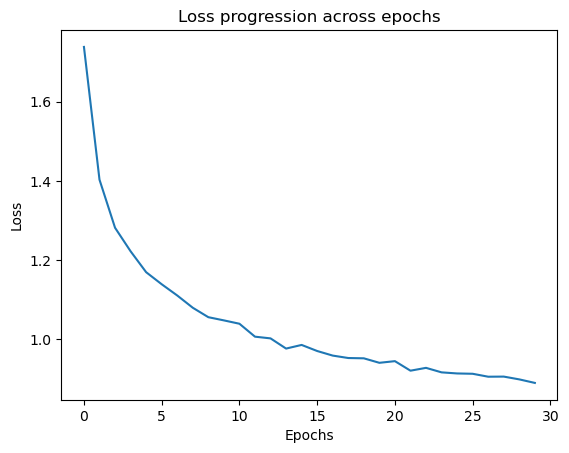

In [31]:
cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.01, momentum=0.9)

train_losses, valid_losses, valid_accs = fit(
        cnn2,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 30,
        device = DEVICE
)

plot_loss(train_losses)

predict(
    cnn2,
    test_dataloader = test_dataloader,
    device = DEVICE
)

**Question** One of the benefits of Batch Norm is that it allows us to use higher learning rates. Adapt the code above to do so. Does the model learn faster?


**Ans** Yes, the model definitely learn faster with the higher learning rate. Based on the results, we can see that using Batch Normalization allows us to increase the learning rate to 0.1 without causing the training to fail. The most obvious sign of this speed is in the very first few epochs.

Although the loss starts at a very high value of 3.35 in Epoch 0, it drops down massively to 1.63 in just one epoch. This is a much sharper decline compared to the previous experiment with the learning rate of 0.01. The steep curve in the plot confirms that the optimizer is taking larger steps toward the minimum and is learning the features of the images much more rapidly.

It is interesting to note that without Batch Normalization, a learning rate of 0.1 might cause the training to diverge or get stuck. However, here the Batch Norm stabilizes the training, allowing the model to recover from the high initial loss and continue decreasing steadily. Even though the final accuracy is 65%, the speed at which the loss decreased in the beginning prove that the model is learning faster.

Epoch 0: Train Loss=379.7538
Epoch 1: Train Loss=696831.2881
Epoch 2: Train Loss=1084722426.2143
Epoch 3: Train Loss=645949676554.4490
Epoch 4: Train Loss=697110840919687.8750
Epoch 5: Train Loss=9151150528556438528.0000
Epoch 6: Train Loss=528045278089230191427584.0000
Epoch 7: Train Loss=15722233819180304952708825088.0000
Epoch 8: Train Loss=722200970880535566657223665909760.0000
Epoch 9: Train Loss=nan
Epoch 10: Train Loss=nan
Epoch 11: Train Loss=nan
Epoch 12: Train Loss=nan
Epoch 13: Train Loss=nan
Epoch 14: Train Loss=nan
Epoch 15: Train Loss=nan
Epoch 16: Train Loss=nan
Epoch 17: Train Loss=nan
Epoch 18: Train Loss=nan
Epoch 19: Train Loss=nan
Epoch 20: Train Loss=nan
Epoch 21: Train Loss=nan
Epoch 22: Train Loss=nan
Epoch 23: Train Loss=nan
Epoch 24: Train Loss=nan
Epoch 25: Train Loss=nan
Epoch 26: Train Loss=nan
Epoch 27: Train Loss=nan
Epoch 28: Train Loss=nan
Epoch 29: Train Loss=nan
Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)


(nan, tensor(10., device='cuda:0'))

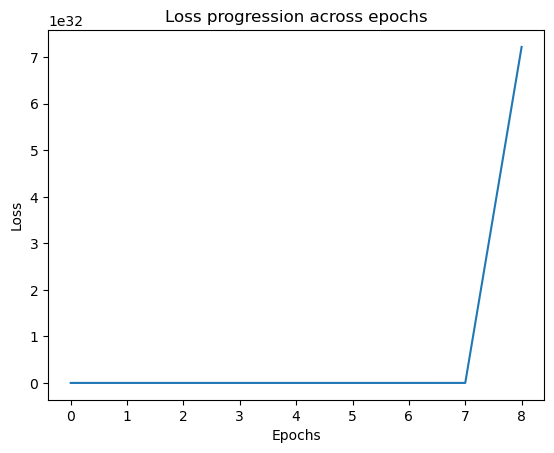

In [32]:
# YOUR CODE HERE 
cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.1, momentum=0.9)

train_losses, valid_losses, valid_accs = fit(
        cnn2,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 30,
        device = DEVICE
)

plot_loss(train_losses)

predict(
    cnn2,
    test_dataloader = test_dataloader,
    device = DEVICE
)

## Learning rate scheduler

We have just seen that batch normalization allows, in this case, for a quicker improvement with a higher learning rate. Still, the loss plateaus quickly and we start seeing minimal improvement. This is often due to the optimization algorithm overshooting the gradient descent.

Can we reduce the step size on the go? Yes! :smiley: This is what learning schedulers are for. The idea is simple: instead of a constant learning rate, we reduce it based on some conditions, or after a certain amount of steps.

Two common schedulers are [`MultiStepLR`][MultiStepLR] and [`ReduceLROnPlateau`][ReduceLROnPlateau]. The first one, simply multiplies our learning rate `lr` by a constant factor $\gamma < 1$ after some predefined number of steps. For instance, if the initial learning rate is `lr=1`, and we set $\gamma=0.5$ for "milestones" of 20 and 50, then the optimizer is going to use `lr=1` for the first 20 epochs, then `lr=0.5` for the subsequent 30, and finally `lr=0.25` for all the remaining ones.

`ReduceLROnPlateau` tracks a given metric, e.g. validation loss or accuracy, and reduces the learning rate if no improvement is seen after a predefined number of steps, called "patience".

[MultiStepLR]: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html
[ReduceLROnPlateau]: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

In the following cell, we augment the `fit` function from previous weeks (in `training_utils.py`) to accept a scheduler argument and use it while training

In [33]:
from training_utils import train_epoch
# from typing import Optional

def fit_scheduler(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None # Scheduler
):
    losses = []
    for epoch in range(epochs):
        running_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device,
        )
        print(f"Epoch {epoch}: Loss={running_loss}")
        losses.append(running_loss)

        if scheduler is not None:
            scheduler.step() # Update the learning rate according to the scheduler (calling step())

    return losses

Now we train again the batch-norm-cnn, using the `MultiStepLR` scheduler.

Epoch 0: Loss=2.1211619742062626
Epoch 1: Loss=1.4834535778785238
Epoch 2: Loss=1.401659513006405
Epoch 3: Loss=1.3124525838968706
Epoch 4: Loss=1.2585782980432316
Epoch 5: Loss=1.205226409191988
Epoch 6: Loss=1.1750720447423506
Epoch 7: Loss=1.1369178392449204
Epoch 8: Loss=1.112476828146954
Epoch 9: Loss=1.0806474503205747
Epoch 10: Loss=1.0660833327137693
Epoch 11: Loss=1.0515866571543169
Epoch 12: Loss=1.0343590232790734
Epoch 13: Loss=1.0309181322856826
Epoch 14: Loss=1.0122211745807104
Epoch 15: Loss=1.011677807691146
Epoch 16: Loss=0.994763369462928
Epoch 17: Loss=0.9913840074928439
Epoch 18: Loss=0.9699997719453306
Epoch 19: Loss=0.9696587774218345
Epoch 20: Loss=0.9589940808257278
Epoch 21: Loss=0.9501762706406263
Epoch 22: Loss=0.9421284162268346
Epoch 23: Loss=0.9382044210725901
Epoch 24: Loss=0.9336514594603558
Epoch 25: Loss=0.8907784783110326
Epoch 26: Loss=0.8788476221415461
Epoch 27: Loss=0.87591666834695
Epoch 28: Loss=0.8728581654782198
Epoch 29: Loss=0.86989308619985

(0.7956623596191407, tensor(73.0300, device='cuda:0'))

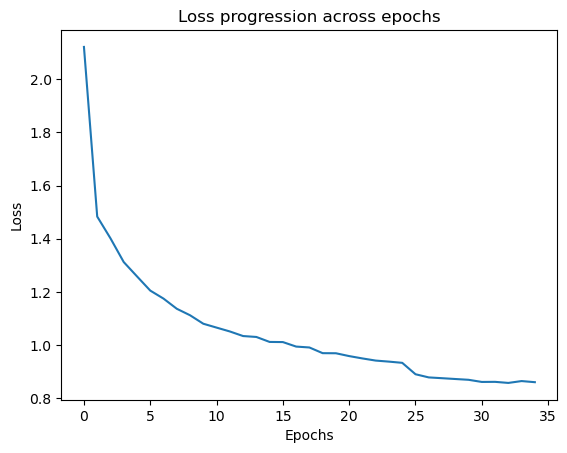

In [34]:
cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.05, momentum=0.9)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[25, 30], # At epoch 25 and 30, reduce LR by a factor of gamma
    gamma=0.1, 
)


losses =   fit_scheduler(
        cnn2,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 35,
        device = DEVICE,
        scheduler=scheduler,
)

plot_loss(losses)

predict(
    cnn2,
    test_dataloader = test_dataloader,
    device = DEVICE
)


## Residual connections

As neural networks go deeper, they are able to construct complex representations and yield superior performance. However, we cannot simply stack as many layers as we want to increase the depth.

![caption](media/resnet-no-skip-horizontal.png)

This is due to the **vanishing gradient** problem. Specifically, backpropagating the gradient to earlier layers involves repeated multiplication (with small values) rendering the gradient extremely small. This effectively means that as we go deeper, performance gets saturated. Instead of improved performance we even have degradation!

How can we reconcile this tradeoff? On the one hand, we want to increase depth but on the other hand this hurts convergence.

Enter **skip connections** [3]! The network of the previous figure now becomes the following:

![caption](media/resnet-horizontal.png)

Now, let's think why these skip connections work. First, they allow the gradient to flow via this shortcut connection, which helps mitigate the problem of vanishing gradient. Second, they allow the model to learn the identity function. In other words, this ensures that the higher layer will perform at least as good as the lower layer.

---
[3] K. He, X. Zhang, S. Ren, and J. Sun, “Deep Residual Learning for Image Recognition,” in 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, Jun. 2016, pp. 770–778. doi: 10.1109/CVPR.2016.90.



First, we build the network of the first image, i.e. with no skip connections. The Resnet depicted above is characterized by an interesting pattern. It consists of "super-blocks" (see the different colors) and each one consists of two blocks that start after one residual connection and finish just before one. Notice that each color is associated with a different number, i.e. 64, 128, 256, 512.

We will build a `nn.Module` for each block and repeat it to create the super-blocks and by extension the whole architecture.

The ResNet depicted above is meant to be used for `ImageNet`, a more complex dataset compared to `CIFAR10`. For computational considerations, we amend our implementation and make a simpler version.

In [35]:
class NonResidualBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels = in_planes,
            out_channels = planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False)

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes,
            planes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        return x


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10): # e.g., num_blocks=[2,2,2,2] for ResNet18, block = NonResidualBlock, can be other blocks too
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride)) #self
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



In [36]:
# initialize the model
model = ResNet(block=NonResidualBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print("Model parameters: ", sum(p.numel() for p in model.parameters()))

Model parameters:  11000138


In [37]:


# train the ResNet

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 35,
        device = DEVICE
    )


Epoch 0: Train Loss=2.2796
Epoch 1: Train Loss=1.9421
Epoch 2: Train Loss=1.7794
Epoch 3: Train Loss=1.6888
Epoch 4: Train Loss=1.5912
Epoch 5: Train Loss=1.4606
Epoch 6: Train Loss=1.3327
Epoch 7: Train Loss=1.2211
Epoch 8: Train Loss=1.1309
Epoch 9: Train Loss=1.0391
Epoch 10: Train Loss=0.9718
Epoch 11: Train Loss=0.9050
Epoch 12: Train Loss=0.8412
Epoch 13: Train Loss=0.7775
Epoch 14: Train Loss=0.7228
Epoch 15: Train Loss=0.6834
Epoch 16: Train Loss=0.6387


KeyboardInterrupt: 

Test set: Avg. loss: 0.9776, Accuracy: 8008/10000 (80%)


(0.9775568969726562, tensor(80.0800, device='cuda:0'))

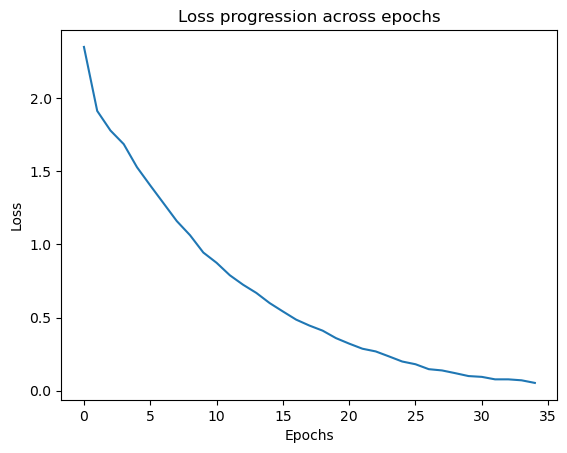

In [ ]:

plot_loss(train_losses)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


### Evaluated part: 

Now, we add skip connections. Notice that sometimes the skip connection cannot be simply an identity function, since the dimensions will not match. Identify the condition when this is necessary. In that case, the shortcut function should be a convolution followed by BatchNorm.

**Question** Fill the code below and train the network!

In [ ]:
class CorrectBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential() # identity by default, identical mapping
        if stride != 1 or in_planes != planes: # if dimensions do not match, we need to adjust
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        # YOUR CODE GOES HERE

        # 1. Preserve the input data to serve as the residual (shortcut) connection.
        # It automatically adjusts dimensions if they mismatch; otherwise, it remains an identity mapping (passing x directly).
        residual = self.shortcut(x)

        # 2. Main Path: Execute standard convolution operations.
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # 3. Core Step: Add the output from the main path to the residual from the shortcut connection.
        out += residual 

        # 4. Apply the final ReLU activation function.
        out = F.relu(out)

        return out

Epoch 0: Train Loss=2.2148
Epoch 1: Train Loss=1.6065
Epoch 2: Train Loss=1.3834
Epoch 3: Train Loss=1.2231
Epoch 4: Train Loss=1.0596
Epoch 5: Train Loss=0.9323
Epoch 6: Train Loss=0.7857
Epoch 7: Train Loss=0.6776
Epoch 8: Train Loss=0.5752
Epoch 9: Train Loss=0.4809
Epoch 10: Train Loss=0.3727
Epoch 11: Train Loss=0.2702
Epoch 12: Train Loss=0.1997
Epoch 13: Train Loss=0.1470
Epoch 14: Train Loss=0.1056
Epoch 15: Train Loss=0.0804
Epoch 16: Train Loss=0.0592
Epoch 17: Train Loss=0.0573
Epoch 18: Train Loss=0.0467
Epoch 19: Train Loss=0.0401
Epoch 20: Train Loss=0.0431
Epoch 21: Train Loss=0.0405
Epoch 22: Train Loss=0.0365
Epoch 23: Train Loss=0.0240
Epoch 24: Train Loss=0.0223
Epoch 25: Train Loss=0.0207
Epoch 26: Train Loss=0.0178
Epoch 27: Train Loss=0.0237
Epoch 28: Train Loss=0.0256
Epoch 29: Train Loss=0.0246
Epoch 30: Train Loss=0.0243
Epoch 31: Train Loss=0.0228
Epoch 32: Train Loss=0.0161
Epoch 33: Train Loss=0.0158
Epoch 34: Train Loss=0.0151
Test set: Avg. loss: 1.4874, A

(1.4874197875976563, tensor(77.9000, device='cuda:0'))

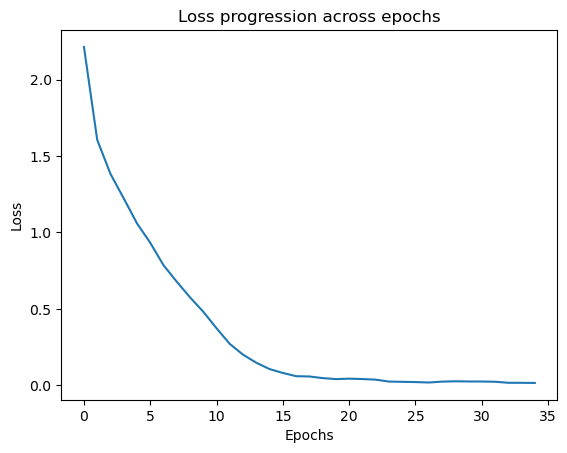

In [ ]:
# initialize the model
model = ResNet(block=CorrectBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        # epochs = 35,
        epochs = 60, # changed from 35 to 60， since data argumentation is used
        device = DEVICE
    )
plot_loss( train_losses )

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)

**Question:** It looks like the model without the residual connections performs better (3-4%), but on a closer examination of the training curves the residual model achieves lower loss much faster and then plateaus. You might try to add a scheduler to boost the performance!

In [ ]:
# Re-initialize the model to start fresh
model = ResNet(block=CorrectBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# Define the optimizer (SGD with momentum is standard for ResNets)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4) # To prevent overfitting, add weight decay (L2 regularization)

# Define the Scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[30, 50], 
    gamma=0.1
)

print("Model parameters: ", sum(p.numel() for p in model.parameters()))

Model parameters:  11173962


Epoch 0: Loss=2.5101453795724984
Epoch 1: Loss=1.8034935703082962
Epoch 2: Loss=1.606535792350769
Epoch 3: Loss=1.46858270314275
Epoch 4: Loss=1.3146464557063824
Epoch 5: Loss=1.165246202021229
Epoch 6: Loss=1.0304197085147002
Epoch 7: Loss=0.9300808699763551
Epoch 8: Loss=0.8341971562833203
Epoch 9: Loss=0.7623379084528709
Epoch 10: Loss=0.6908593469736527
Epoch 11: Loss=0.6262097529002598
Epoch 12: Loss=0.5807943380608851
Epoch 13: Loss=0.5325749741525067
Epoch 14: Loss=0.496820081253441
Epoch 15: Loss=0.45993170263815897
Epoch 16: Loss=0.41598869829761737
Epoch 17: Loss=0.4039642750000467
Epoch 18: Loss=0.3815789849174266
Epoch 19: Loss=0.3596467801502773
Epoch 20: Loss=0.3494576319139831
Epoch 21: Loss=0.32341176636364993
Epoch 22: Loss=0.30405253749720906
Epoch 23: Loss=0.29385895510109106
Epoch 24: Loss=0.27462493856342474
Epoch 25: Loss=0.26457119018447645
Epoch 26: Loss=0.2493985173653583
Epoch 27: Loss=0.23593410363002698
Epoch 28: Loss=0.21837806975354954
Epoch 29: Loss=0.212

(0.3077652862548828, tensor(91.3300, device='cuda:0'))

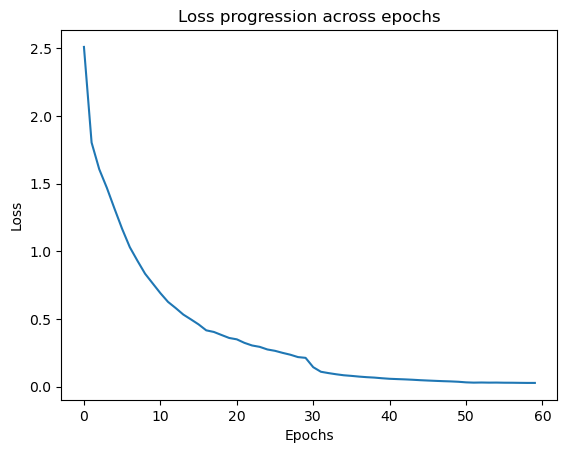

In [ ]:
# Train using the fit_scheduler function
# Make sure to use fit_scheduler, not just fit, so the LR updates happen!
train_losses = fit_scheduler(
    model=model,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=60, # again, 60 epochs due to data augmentation
    device=DEVICE,
    scheduler=scheduler
)

plot_loss(train_losses)

predict(
    model,
    test_dataloader=test_dataloader,
    device=DEVICE
)

### **Ans** 

My initial model performed well but I noticed signs of overfitting, where the training loss was very low but the test accuracy plateaued around 80%. To address this, I implemented several strategies to improve the model's generalization and overall performance.

First, I added data augmentation to the training process. This involved using random cropping and horizontal flipping on the training images. By artificially expanding the dataset, the model was forced to learn more robust features rather than just memorizing the specific training examples. I also used standard normalization for both the training and test sets to ensure the input data had a consistent distribution. This step was crucial for helping the model converge more effectively.

Second, I optimized the training process by tuning hyperparameters. I used SGD with momentum to accelerate convergence and added weight decay (L2 regularization) to prevent the weights from growing too large, which helps control overfitting. I also implemented a learning rate scheduler that reduced the learning rate at specific epochs (30 and 50). This allowed the model to make large updates early in training and then fine-tune its parameters as it approached the optimal solution.

Finally, I increased the number of training epochs to 60. This gave the model more time to learn from the augmented data, which is inherently more difficult to fit than the original data. The results were significant: the training loss stabilized at a healthy level, indicating the model was learning rather than memorizing, and the test accuracy improved to 91%. This demonstrates that the combination of a strong architecture (ResNet), data augmentation, and careful hyperparameter tuning led to a highly effective model.